In [ ]:
# import the usual suspects
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

In [ ]:
# function to generate the stock price series
def generate_paths(spot, drift, sigma, years, points, sims):
    # create numpy PCG PRNG
    rng = np.random.default_rng(seed=123)
    # create random numbers
    dW = rng.normal(size=(sims, points * years))
    # get our scaled random deviations
    scaled_dW = dW * (sigma / points**0.5)
    # add on the drift
    daily_devs = (drift / points) + scaled_dW
    # cumsum them as log returns additive
    cum_rets = np.cumsum(daily_devs, axis=1)
    # add in 0 at start for starting price
    cum_rets = np.insert(cum_rets, 0, 0, axis=1)
    # create price series
    pxs = spot * np.exp(cum_rets)

    return daily_devs, pxs

# functions to compute Black-Scholes option prices
def bs_d_one(S, K, rf, div, sigma, delta_T):
  return (1 / (sigma * delta_T**0.5)) * (np.log(S / K) + (rf - div + (sigma**2)/2) * delta_T)

def bs_d_two(S, K, rf, div, sigma, delta_T):
  return bs_d_one(S, K, rf, div, sigma, delta_T) - (sigma * delta_T**0.5)


def compute_prices(pxs, K, rf, div, sigma, points, years, call=True):
  # create time vector
  times = np.linspace(0, years, (points*years) + 1)[::-1]

  # calculate d1 and d2
  d_one = bs_d_one(pxs, K, rf, div, sigma, times)
  d_two = bs_d_two(pxs, K, rf, div, sigma, times)

  # compute deltas and prices
  if call:
    deltas = stats.norm.cdf(d_one)
    prices = pxs * np.exp(-div * times) * deltas - stats.norm.cdf(d_two) * K * np.exp(-rf * times)
    gammas = stats.norm.pdf(d_one) / (pxs * sigma * np.sqrt(times))

  else:
    deltas = stats.norm.cdf(d_one) - 1
    prices = stats.norm.cdf(-d_two) * K * np.exp(-rf * times) + deltas * pxs * np.exp(-div * times)
    gammas = stats.norm.pdf(d_one) / (pxs * sigma * np.sqrt(times))

  return prices, deltas, gammas

In [ ]:
# determine our process parameters
px = 100
sigma = 0.25
risk_free = 0.05
divs = 0.00
K = 100
call = True

# determine our sim settings, i.e. we want 10,000 sets of 252 random numbers
sims = 10000
points = 252
years = 1

# generate sims
rets, pxs = generate_paths(px, risk_free - divs, sigma, years, points, sims)

# estimate option tvs, deltas and gammas
call_pxs, deltas, gammas = compute_prices(pxs, K, risk_free, divs, sigma, points, years, call)

In [ ]:
# Compute cash flows from various activities at each point we will add on cash flows
# to the future valued version of last period's cash balance
# this gives us our new cash balance

# Compute stock values at each point in time
stock_values = pxs * deltas

# Cash flow from delta hedging
# Compute cash generated from delta re-hedging
delta_chgs = np.diff(deltas, axis=1)
delta_rehedge_cfs = -delta_chgs * pxs[:,1:]

# Compute dividend income
div_cfs = deltas[:,:-1] * pxs[:,:-1] * divs / points

# Compute starting premium and delta cfs
start_cbs = call_pxs[:,0] - deltas[:,0] * pxs[:,0]

# Initialize our cash balance and cashflow arrays
cbs = [start_cbs]
cfs = [np.zeros(sims)]

for drh, dcf in zip(delta_rehedge_cfs.T, div_cfs.T):
    # get previous cash balance
    prev_cash = cbs[-1]
    # future value it
    new_cash = prev_cash * (1 + risk_free / points)
    # add on new cash flows
    cf = drh + dcf
    cb = new_cash + cf
    cfs.append(cf)
    cbs.append(cb)

cfs = np.array(cfs).T
cbs = np.array(cbs).T

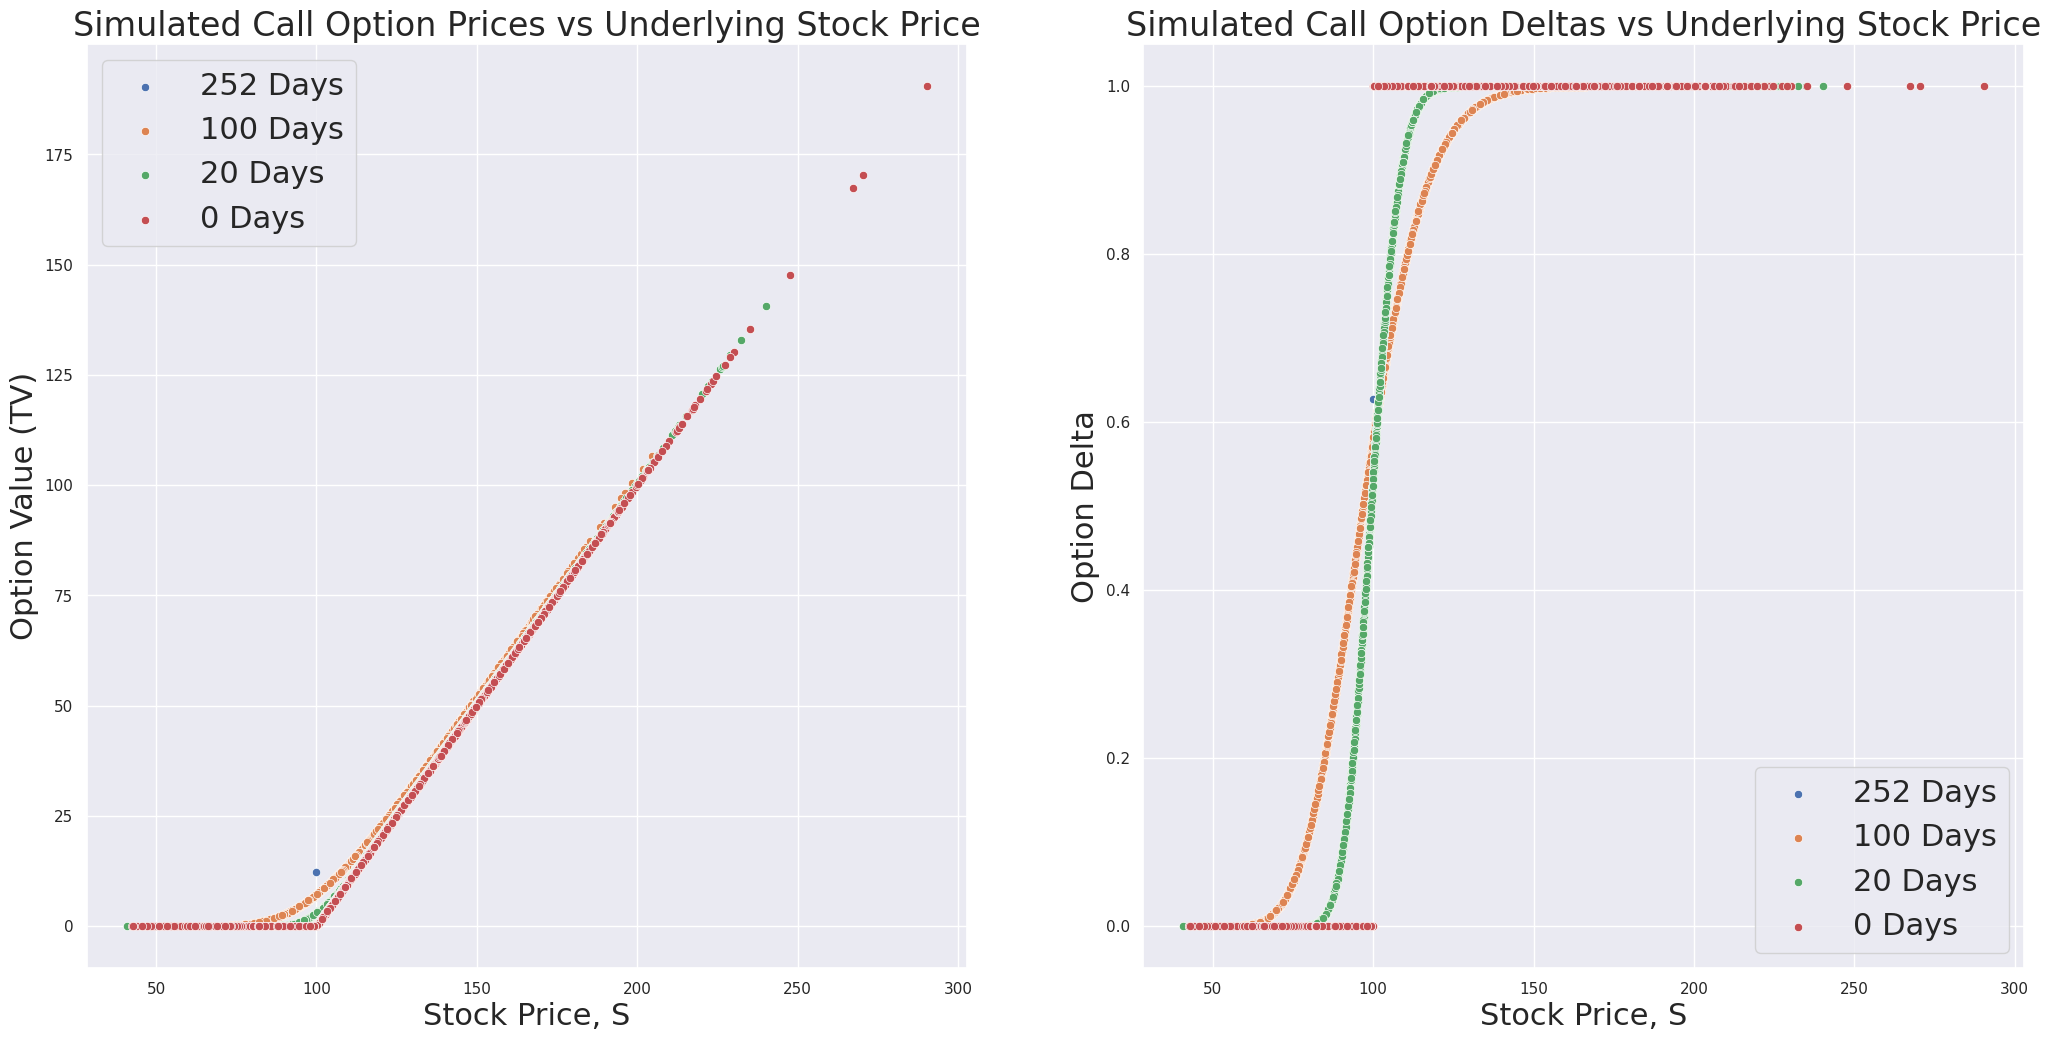

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 12))
axes = axes.reshape(-1)

ts = [-253, -101, -21, -1]

for t in ts:
  # initialize list of lists
  data = {'stock_prices': pxs[:,t], 'call_prices': call_pxs[:,t], 'call_deltas': deltas[:,t]}
  sns.scatterplot(data = data, x = "stock_prices", y = "call_prices", ax=axes[0], label="{} Days".format(-t-1))
  sns.scatterplot(data = data, x = "stock_prices", y = "call_deltas", ax=axes[1], label="{} Days".format(-t-1))

axes[0].set_title('Simulated Call Option Prices vs Underlying Stock Price', fontsize=24)
axes[0].set_xlabel('Stock Price, S', fontsize=22)
axes[0].set_ylabel('Option Value (TV)', fontsize=22)
axes[0].legend(fontsize=22)

axes[1].set_title('Simulated Call Option Deltas vs Underlying Stock Price', fontsize=24)
axes[1].set_xlabel('Stock Price, S', fontsize=22)
axes[1].set_ylabel('Option Delta', fontsize=22)
axes[1].legend(fontsize=22);

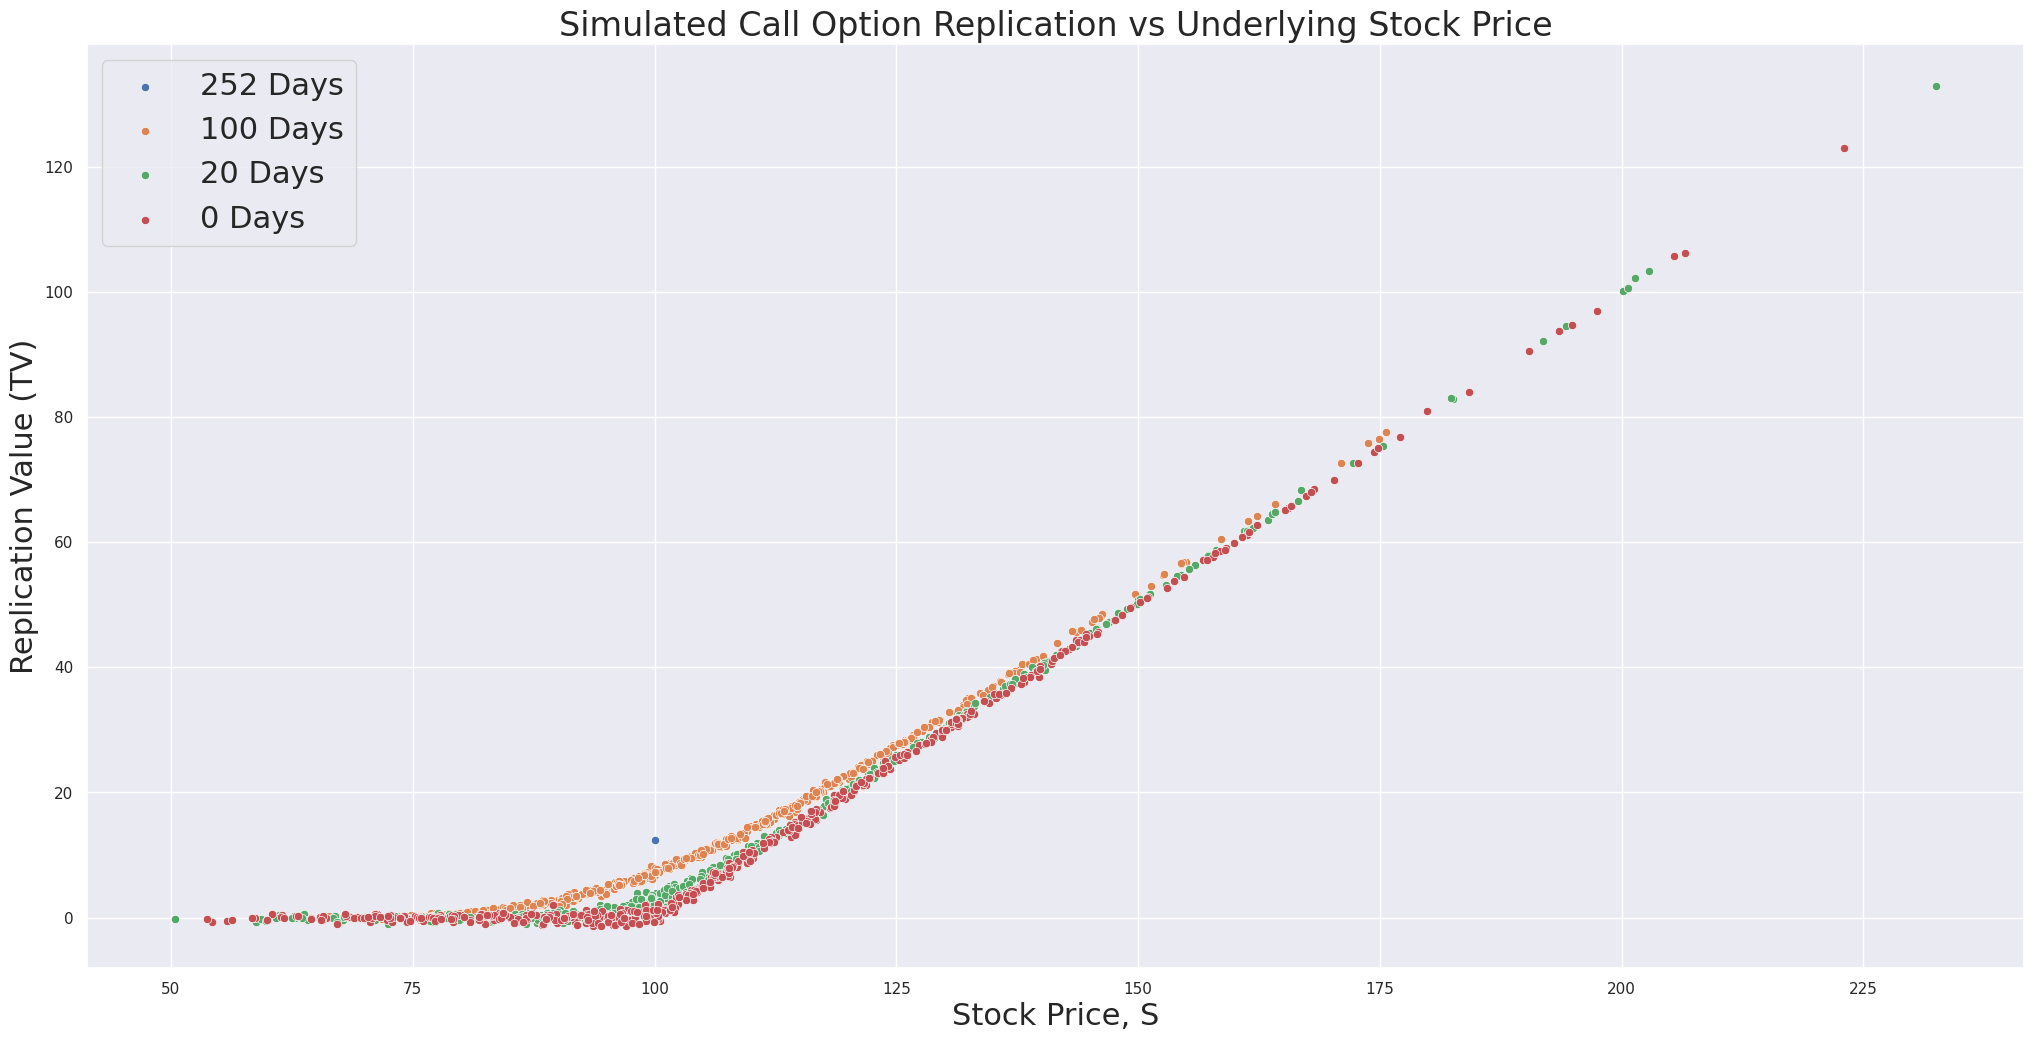

In [ ]:
fig, ax = plt.subplots(figsize=(25, 12))
for t in ts:
    data = {'stock_prices': pxs[:500, t], 'cash_balance_plus_stock_price': cbs[:500, t] + stock_values[:500, t]}
    sns.scatterplot(data = data, x = "stock_prices", y = "cash_balance_plus_stock_price", label="{} Days".format(-t-1))

ax.set_title('Simulated Call Option Replication vs Underlying Stock Price', fontsize=24)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Replication Value (TV)', fontsize=22)
ax.legend(fontsize=22);